In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import scipy.io

#updated below function so that it will only take in the first 3 min for calculations...
def calculate_frame_brightness(video_path, max_frames):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    frame_brightness = []
    frame_number = 0
    # max_frames = 500
    
    while frame_number < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate the average brightness
        avg_brightness = np.mean(gray_frame)
        frame_brightness.append(avg_brightness)
        
        frame_number += 1
    
    cap.release()
    return frame_brightness

def find_brightness_drop(brightness_values, threshold):
    drops = []
    for i in range(1, len(brightness_values)): 
        if brightness_values[i-1] - brightness_values[i] > threshold:
            drops.append(i)
    return drops

def process_videos(base_path, threshold, max_frames):
    drop_frames = {}
    cameras = [f'Camera{i}' for i in range(1, 7)] 
    for camera in cameras:
        video_path = os.path.join(base_path, camera, '0.mp4')
        brightness_values = calculate_frame_brightness(video_path, max_frames)
        
        drop_frame = find_brightness_drop(brightness_values, threshold)
        if drop_frame is not None:
            drop_frames[camera] = drop_frame
        else:
            print(f"No significant drop found in first 3 min in {video_path}")

        plt.plot(brightness_values, label=camera)
    
    plt.title('Frame Brightness Over Time')
    plt.xlabel('Frame Number, first 3 min')
    plt.ylabel('Average Brightness')
    plt.legend()
    plt.show()

    return drop_frames


def align_frames(data_sampleID, drop_frame):
    new_sampleID = data_sampleID.copy()
    num_frames = data_sampleID.size

    # Set the drop frame to 0
    new_sampleID[drop_frame] = 0

    # Adjust frames after the drop frame
    new_sampleID[drop_frame+1:] = range(1, num_frames - drop_frame)

    # Adjust frames before the drop frame
    new_sampleID[:drop_frame] = range(-drop_frame, 0)

    return new_sampleID




def update_calib(calib_file, drop_frames, save_path):

    calib_data = scipy.io.loadmat(calib_file)
    sync = calib_data['sync']

    for cam_idx in range(6):
        camera_key = f'Camera{cam_idx+1}'  # 2, 7 if camera 1 is dead
        drop_frame = drop_frames[camera_key][0]

        # Access the data_sampleID for the current camera
        data_sampleID = sync[cam_idx][0]['data_sampleID'][0][0][0] #data_sampleID

        # Align the frames
        new_data_sampleID = align_frames(data_sampleID, drop_frame)

        # Update the sync structure with the new data_sampleID
        sync[cam_idx][0]['data_sampleID'][0][0][0] = new_data_sampleID #data_sampleID


    # Find common frame numbers across all cameras
    keyyyyy = 'data_sampleID'
    all_frames = [sync[cam_idx][0][keyyyyy][0][0][0] for cam_idx in range(6)] #data_sampleID
    common_frames = set(all_frames[0])
    for frames in all_frames[1:]:
        common_frames.intersection_update(frames)

    # Mark frames not in common set as NaN
    for cam_idx in range(6):
        data_sampleID = sync[cam_idx][0][keyyyyy][0][0][0] #data_sampleID
        mask = np.isin(data_sampleID, list(common_frames))
        data_sampleID[~mask] = np.nan

        #test if this will change things positive/start with 0
        counter = 0
        for i in range(len(data_sampleID)):
            # for 0, not for pos, not for nan
            # if mask[i]:  # Only adjust for frames in the common set
            #     data_sampleID[i] = counter
            #     counter += 1
            # else:
            #     data_sampleID[i] = 0  # Set non-matching frames to 0
            # below is for the nan thing... hh
            if np.isnan(data_sampleID[i]):
                counter = 0  # Reset counter after NaN
            elif mask[i]:  # Adjust only for frames in the common set
                data_sampleID[i] = counter
                counter += 1

        sync[cam_idx][0][keyyyyy][0][0][0] = data_sampleID #data_sampleID

    calib_data['sync'] = sync
    scipy.io.savemat(save_path, calib_data)
    print('alined data saved to:', save_path)


def find_calib_file(date_path):
    for file_name in os.listdir(date_path):
        if file_name.endswith('label3d_dannce.mat'):
            return os.path.join(date_path, file_name)
    return None

def process_folders(base_path, dates, threshold=3, max_frames=500, stepmax_frame = 1000):
    missing_folders = []
    successful_folders = []

    for date in dates:
        date_path = os.path.join(base_path, date)
        if not os.path.exists(date_path):
            print(f"Date folder {date_path} does not exist. Skipping.")
            continue

        calib_file = find_calib_file(date_path)
        # print(calib_file)
        if not calib_file:
            print(f"No calibration file found in {date_path}. Skipping.")
            continue

        calib_nammm = os.path.basename(calib_file)
        # print(calib_nammm)

        for folder_name in os.listdir(date_path):
            folder_path = os.path.join(date_path, folder_name)

            if os.path.isdir(folder_path) and folder_name[0].isdigit():
                save_path = os.path.join(folder_path, f'pos_synced_{folder_name}_{calib_nammm}') #f'pos_synced_{folder_name}_{calib_nammm}'
                vi_path = os.path.join(folder_path, 'videos')

                drop_frames = process_videos(vi_path, threshold, max_frames)
                print(f"Detected intensity drop frames in {folder_name}:", drop_frames)

                if any(len(frames) == 0 for frames in drop_frames.values()):
                    missing_folders.append(folder_path)
                    print(f"Skipping process_calibration_data for {folder_name} due to missing drop frames")
                else:
                    successful_folders.append(folder_path)
                    update_calib(calib_file, drop_frames, save_path)
                    # print('h')

    print('Missing folders:', missing_folders)
    return missing_folders, successful_folders

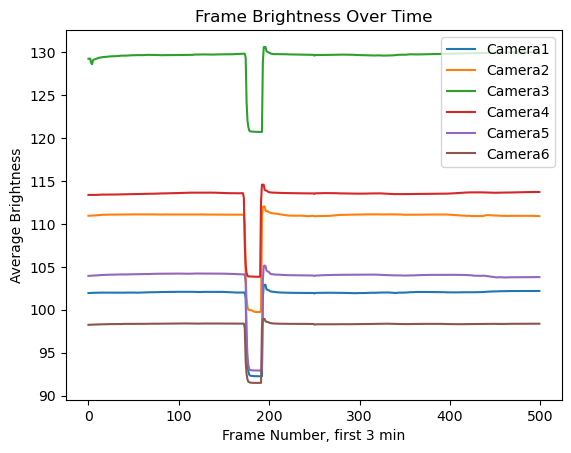

Detected intensity drop frames in 1691486NMCFS1123: {'Camera1': [175], 'Camera2': [174], 'Camera3': [175], 'Camera4': [173], 'Camera5': [175], 'Camera6': [174]}
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_16/1691486NMCFS1123/pos_synced_1691486NMCFS1123_calib_test_offset_3_38_label3d_dannce.mat


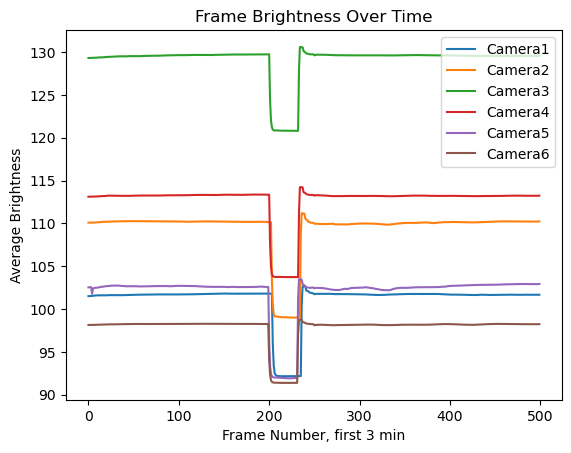

Detected intensity drop frames in 1691485RMCFF1500: {'Camera1': [204], 'Camera2': [203], 'Camera3': [201], 'Camera4': [201], 'Camera5': [200], 'Camera6': [200]}
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_16/1691485RMCFF1500/pos_synced_1691485RMCFF1500_calib_test_offset_3_38_label3d_dannce.mat


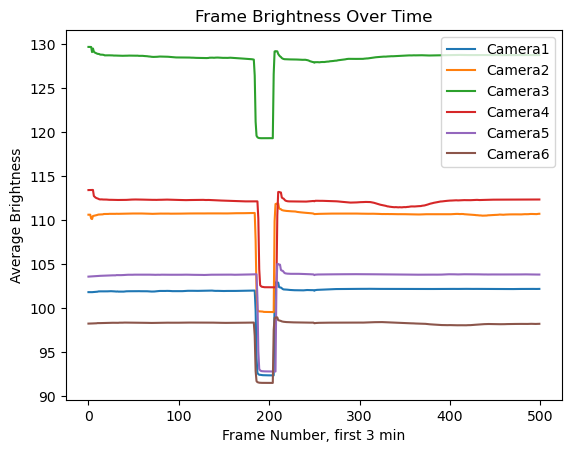

Detected intensity drop frames in 1691485RMHBN1405: {'Camera1': [186], 'Camera2': [185, 186], 'Camera3': [185], 'Camera4': [189], 'Camera5': [188], 'Camera6': [185]}
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_16/1691485RMHBN1405/pos_synced_1691485RMHBN1405_calib_test_offset_3_38_label3d_dannce.mat


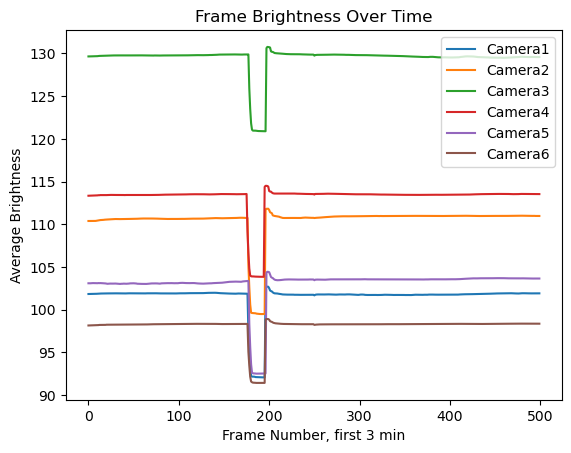

Detected intensity drop frames in 1691485RMCFS1535: {'Camera1': [177], 'Camera2': [177], 'Camera3': [178], 'Camera4': [176], 'Camera5': [178], 'Camera6': [177]}
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_16/1691485RMCFS1535/pos_synced_1691485RMCFS1535_calib_test_offset_3_38_label3d_dannce.mat


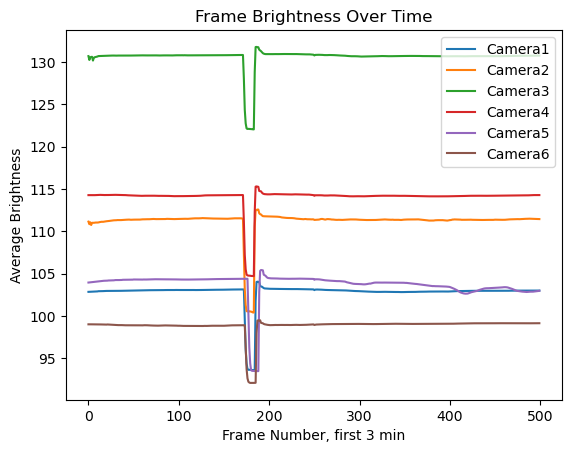

Detected intensity drop frames in 1691486NMHBN0927: {'Camera1': [173, 174], 'Camera2': [172, 173], 'Camera3': [173], 'Camera4': [172, 173], 'Camera5': [177, 178], 'Camera6': []}
Skipping process_calibration_data for 1691486NMHBN0927 due to missing drop frames


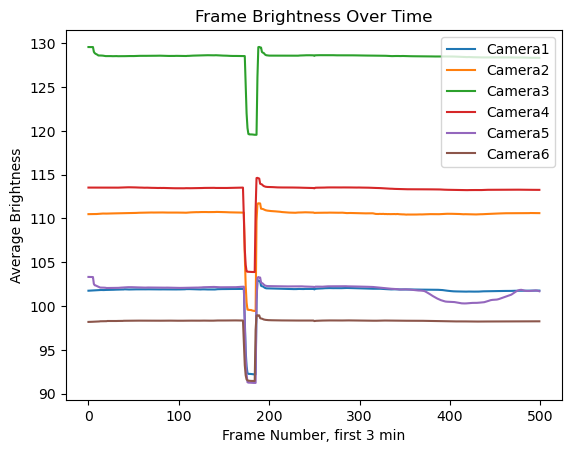

Detected intensity drop frames in 1691486NMCFF1033: {'Camera1': [173, 174], 'Camera2': [173, 174], 'Camera3': [174, 175], 'Camera4': [172, 173], 'Camera5': [173, 174], 'Camera6': []}
Skipping process_calibration_data for 1691486NMCFF1033 due to missing drop frames
Missing folders: ['/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_16/1691486NMHBN0927', '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_16/1691486NMCFF1033']


In [3]:
from datetime import datetime
# Define the dates you want to process
dates = ['2024_07_16'] # '2024_07_01', '2024_07_02', '2024_06_25' '2024_07_03' '2024_07_08', '2024_07_09', '2024_07_10', '2024_07_12', '2024_07_15', '2024_07_16'

# Define the base path
base_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ'
synced_name_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/mir_bundle_run/synced_folders'

# Call the function to process folderss
missing_folders, successful_folders = process_folders(base_path, dates, threshold=3) #threshold=3, max_frames=500, (stepmax_frame=1000 function under development, idealy we don't need it if swiched early, but should be flexiable...
# process_folders(base_path, dates)
now = datetime.now()
date_time_str = now.strftime("%Y%m%d_%H%M%S")
np.save(os.path.join(synced_name_path,f'{date_time_str}_successful_folders.npy'), successful_folders)
np.save(os.path.join(synced_name_path,f'{date_time_str}_missing_folders.npy'), missing_folders)

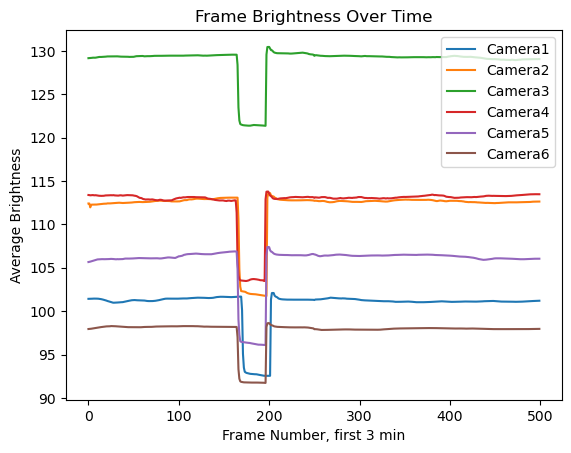

Detected intensity drop frames in 240605PMC_window2_right2holes_12_14: {'Camera1': [171], 'Camera2': [167], 'Camera3': [166], 'Camera4': [165], 'Camera5': [166], 'Camera6': [166]}
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_19/240605PMC_window2_right2holes_12_14/pos_synced_240605PMC_window2_right2holes_12_14_calib_test_offset_3_38_label3d_dannce.mat


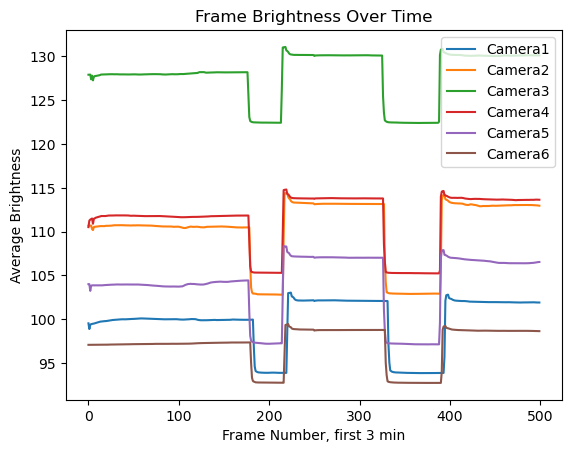

Detected intensity drop frames in 240605PMC_window2_right2holes_11_30: {'Camera1': [183, 332], 'Camera2': [179, 328], 'Camera3': [326], 'Camera4': [327], 'Camera5': [178, 327], 'Camera6': [329]}
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_19/240605PMC_window2_right2holes_11_30/pos_synced_240605PMC_window2_right2holes_11_30_calib_test_offset_3_38_label3d_dannce.mat
Missing folders: []


In [4]:
from datetime import datetime
# Define the dates you want to process
dates = ['2024_07_19'] # '2024_07_01', '2024_07_02', '2024_06_25' '2024_07_03' '2024_07_08', '2024_07_09', '2024_07_10', '2024_07_12', '2024_07_15', '2024_07_16'

# Define the base path
base_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ'
synced_name_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/mir_bundle_run/synced_folders'

# Call the function to process folderss
missing_folders, successful_folders = process_folders(base_path, dates, threshold=5) #threshold=3, max_frames=500, (stepmax_frame=1000 function under development, idealy we don't need it if swiched early, but should be flexiable...
# process_folders(base_path, dates)
# now = datetime.now()
# date_time_str = now.strftime("%Y%m%d_%H%M%S")
# np.save(os.path.join(synced_name_path,f'{date_time_str}_successful_folders.npy'), successful_folders)
# np.save(os.path.join(synced_name_path,f'{date_time_str}_missing_folders.npy'), missing_folders)

In [11]:
missing_folders

['/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1038',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_1439',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_1459',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_test_1438',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1025',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1046_test',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_1349',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1035',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1032',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_1433',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_09/1691486_right_hole_

In [12]:
# aaa = np.load('/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/mir_bundle_run/synced_folders/20240710_195618_missing_folders.npy')

In [14]:
# aaa

array(['/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1038',
       '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_1439',
       '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_1459',
       '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_test_1438',
       '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1025',
       '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1046_test',
       '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_1349',
       '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1035',
       '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_no_hole_saline_1032',
       '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_08/1691486_right_baseline_1433',
       '/hpc/group/t

In [12]:
missing_folders
# ['/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_no_hole_caffine',
#  '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_no_hole_caffine_11_40',
#  '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_no_hole_caffine_13_10',
#  '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_left_hole_caffeine_16_42',
#  '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_left_hole_caffeine_16_37',
#  '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_no_hole_caffine_13_15',
#  '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_left_hole_caffeine_16_50',
#  '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_25/1686940_left_right',
#  '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_25/1686940_left_right_2']

['/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_no_hole_caffine',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_no_hole_caffine_11_40',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_no_hole_caffine_13_10',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_left_hole_caffeine_16_42',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_left_hole_caffeine_16_37',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_no_hole_caffine_13_15',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_07_01/230815PMC_left_hole_caffeine_16_50',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_25/1686940_left_right',
 '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_25/1686940_left_right_2']

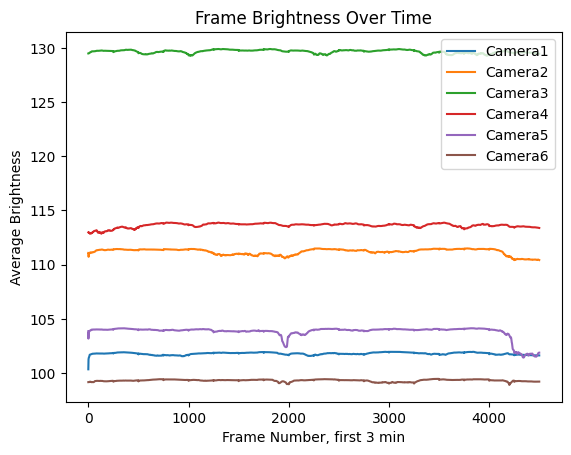

Detected intensity drop frames: {'Camera1': [], 'Camera2': [], 'Camera3': [], 'Camera4': [], 'Camera5': [], 'Camera6': []}


In [6]:
# # Define base path and camera list
# # mannual script
# base_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_27/1686940_right_2' # where your video folder located
# #potentially change below to only one humm.
# calib_file = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_27/2024_06_27_1686940_1686941_left_label3d_dannce.mat' # os.path.join(base_path,'2024_06_27_1686940_1686941_left_label3d_dannce.mat') # os.path.join(base_path, '30s_exposuretest_label3d_dannce.mat')
# save_path = os.path.join(base_path, 'pos_synced_2024_06_27_1686940_1686941_left_label3d_dannce.mat') # change name here, so that you can find the origional calibration files, you have too keep label_3d.mat for it to work
# threshold = 3  # Adjust this threshold if needed
# max_frames = 4500

# vi_path = os.path.join(base_path, 'videos')

# # Process videos and find brightness drops
# drop_frames = process_videos(vi_path, threshold, max_frames)
# print("Detected intensity drop frames:", drop_frames)


In [ ]:
# process_calibration_data(calib_file, drop_frames, save_path)